### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

## Data collection

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[1]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

C:\Users\Mathieu\AppData\Local\Temp\ipykernel_35068\1533806481.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[1]['Symbol'].tolist()


In [23]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)')


In [24]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
len(selected_stocks)

372

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
index_returns = np.log(data['Close'][selected_stocks]).diff()['^GSPC']
df = (np.log(data['Close'][selected_stocks[:-1]]).diff()*1e4).stack().reset_index(level=1).rename(columns={0: 'close_1d_ret'})

In [7]:
df['close_1d_ret_hedged'] = np.log(data['Close'][selected_stocks[:-1]]).diff().sub(index_returns, axis=0).stack().values*1e4

In [8]:
df = df.merge((np.log(data['Close'][selected_stocks[:-1]])-np.log(data['Open'][selected_stocks[:-1]])).stack().to_frame().rename(columns={0: 'open_close_ret'})*1e4, on=['Date', 'Ticker'], how='left')

In [9]:
df = df.merge((np.log(data['Close'][selected_stocks[:-1]])-np.log(data['Open'][selected_stocks[:-1]])).sub((np.log(data['Close']['^GSPC'])-np.log(data['Open']['^GSPC'])), axis=0).stack().to_frame().rename(columns={0: 'open_close_ret_hedged'})*1e4, on=['Date', 'Ticker'], how='left')

In [10]:
df = df.merge((np.log(data['High'][selected_stocks[:-1]])-np.log(data['Low'][selected_stocks[:-1]])).stack().to_frame().rename(columns={0: 'high_low_ret'})*1e4, on=['Date', 'Ticker'], how='left')

In [11]:
df = df.merge((np.log(data['High'][selected_stocks[:-1]])-np.log(data['Low'][selected_stocks[:-1]])).sub((np.log(data['High']['^GSPC'])-np.log(data['Low']['^GSPC'])), axis=0).stack().to_frame().rename(columns={0: 'high_low_ret_hedged'})*1e4, on=['Date', 'Ticker'], how='left')

In [12]:
df = df.merge(data['Volume'][selected_stocks[:-1]].stack().reset_index(level=1).rename(columns={0: 'volume'}), on=['Date', 'Ticker'], how='left')

In [13]:
df = df.merge(data['Volume'][selected_stocks[:-1]].div(data['Volume'][selected_stocks[:-1]].sum(1), axis=0).stack().reset_index(level=1).rename(columns={0: 'share_volume'}), on=['Date', 'Ticker'], how='left')

## Feature factory

In [14]:
def daily_metrics(group, feature, target, beta_global):
    reg = LinearRegression(fit_intercept=False)
    if len(group) < 2:
        return pd.Series({'beta': np.nan, 'bias': np.nan})
    reg.fit(group[[feature]], group[target])
    predictions = reg.predict(group[[feature]])
    bias = np.std(predictions)
    if reg.coef_[0]*beta_global < 0:
        bias *= -1
    return pd.Series({'bias': bias})

In [15]:
def single_feature_metrics(df, feature, target, fit_intercept=False):
    global_reg = LinearRegression(fit_intercept=fit_intercept)
    first_perc, last_perc = np.percentile(df[feature].dropna(), [1, 99])
    df_filtered = df[(df[feature]>=first_perc) & (df[feature]<=last_perc)]
    global_reg.fit(df_filtered[[feature]], df_filtered[target])
    predictions = global_reg.predict(df_filtered[[feature]])
    bias = np.std(predictions)
    stab = (predictions * df_filtered[target] > 0).mean() * 100
    beta_global = global_reg.coef_[0]
    bias_ts = df_filtered.groupby('Date').apply(lambda x: daily_metrics(x, feature, target, beta_global))
    mean_bias_ts = bias_ts['bias'].mean()
    sharpe_ts = bias_ts['bias'].mean() / bias_ts['bias'].std() * np.sqrt(252)
    return bias, mean_bias_ts, stab, beta_global, sharpe_ts, bias_ts

In [16]:
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift(1)
for h in [3, 5, 10, 20, 50, 100]:
    df[f'avg_ret_hedged_{h}d'] = df.groupby('Ticker')['close_1d_ret_hedged'].transform(lambda x: x.rolling(h).mean().shift())

In [18]:
dict_results = {'avg_ret_hedged': {}}
for h in tqdm([3, 5, 10, 20, 50, 100]): 
    dict_results['avg_ret_hedged'][h] = single_feature_metrics(df, f'avg_ret_hedged_{h}d', 'close_1d_ret_hedged')

100%|██████████| 6/6 [04:25<00:00, 44.20s/it]


In [17]:
for h in [3, 5, 10, 20, 50, 100]:
    for clip in [100, 200, 300, 400]:
        df[f'avg_ret_hedged_{h}d_clip{clip}'] = df[f'avg_ret_hedged_{h}d'].clip(-clip, clip)

In [20]:
dict_results['avg_ret_hedged_clip'] = {}
for h in tqdm([3, 5, 10, 20, 50, 100]):
    for clip in [100, 200, 300, 400]:
        dict_results['avg_ret_hedged_clip'][(h, clip)] = single_feature_metrics(df, f'avg_ret_hedged_{h}d_clip{clip}', 'close_1d_ret_hedged')

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [17:53<00:00, 178.99s/it]


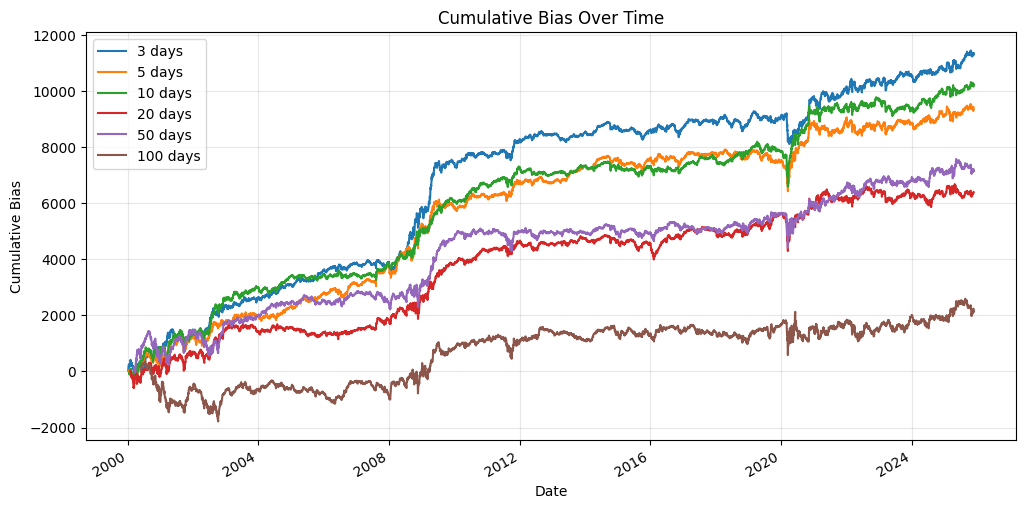

In [21]:
plt.figure(figsize=(12, 6))
for h in dict_results['avg_ret_hedged'].keys():
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()

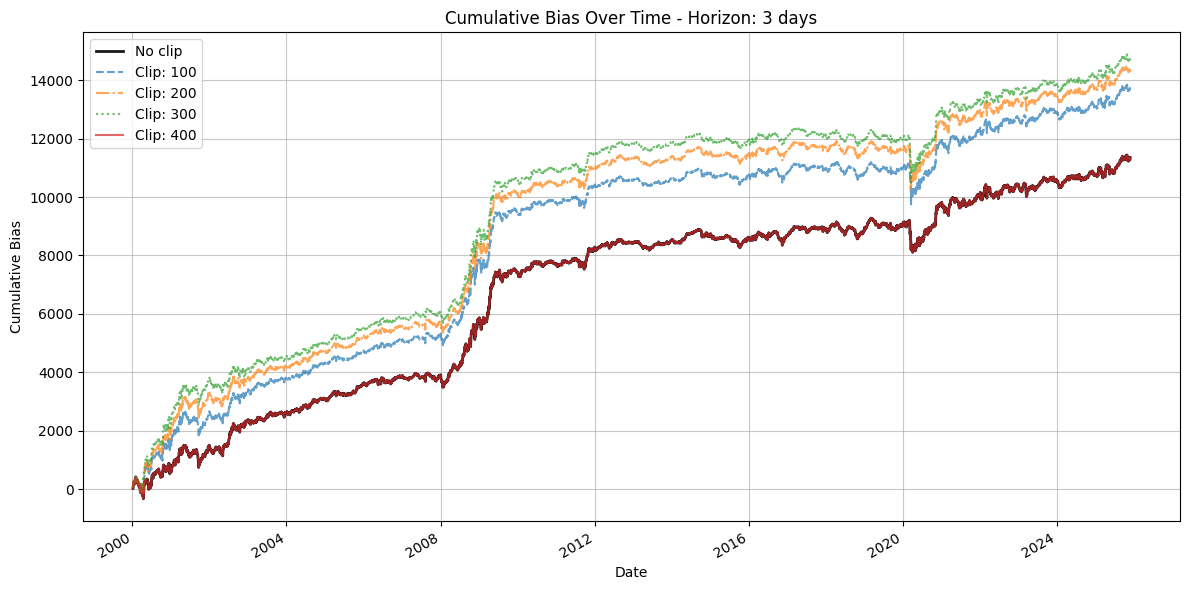

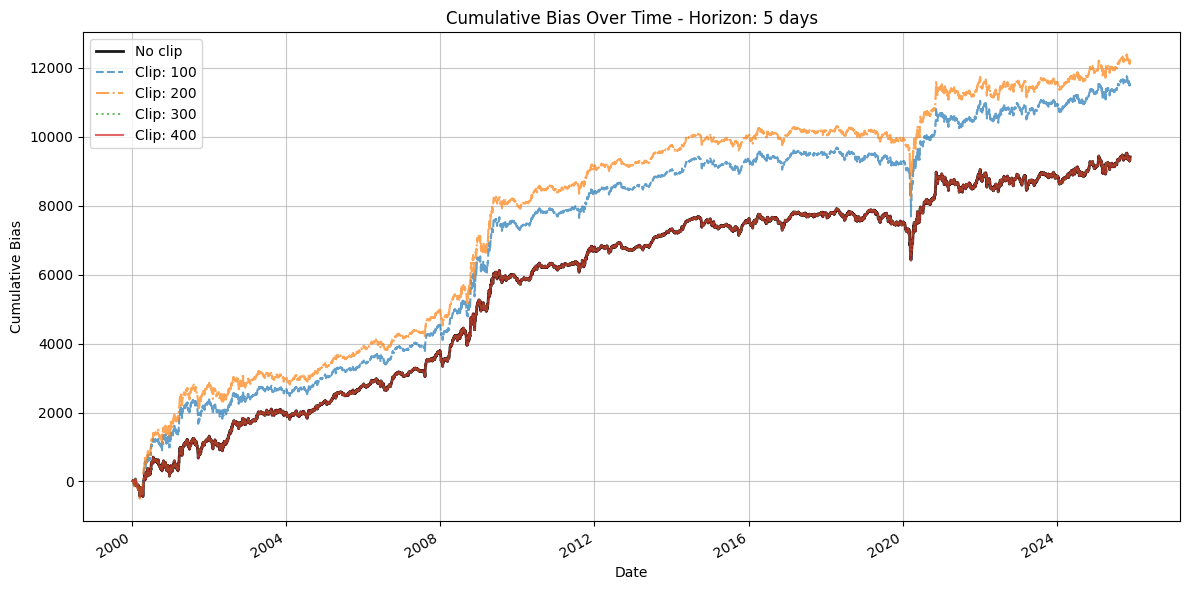

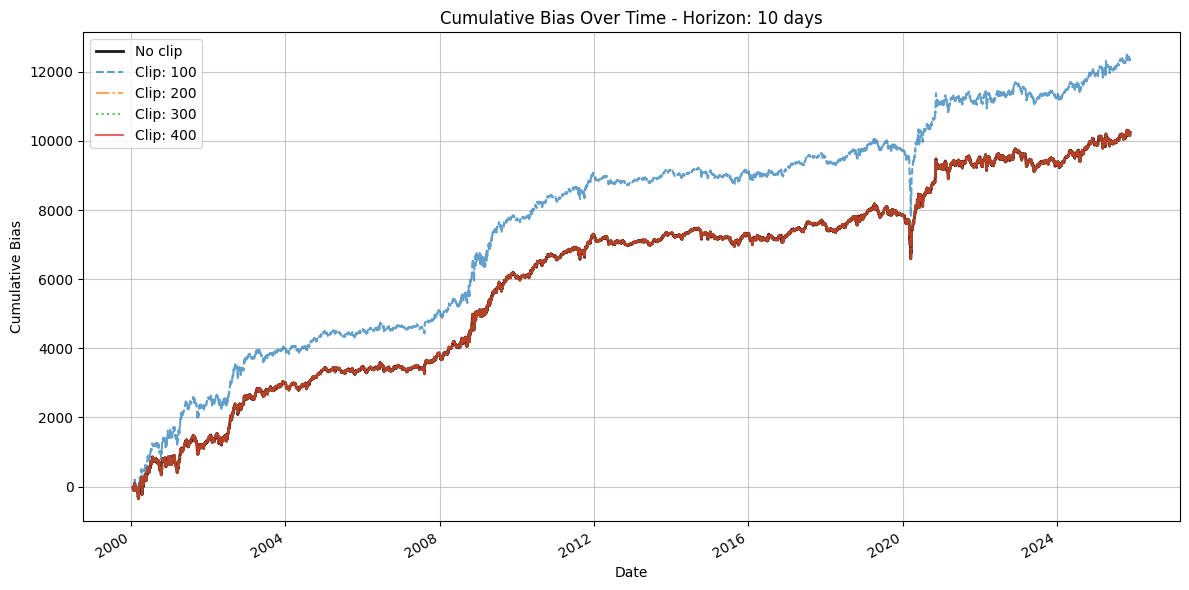

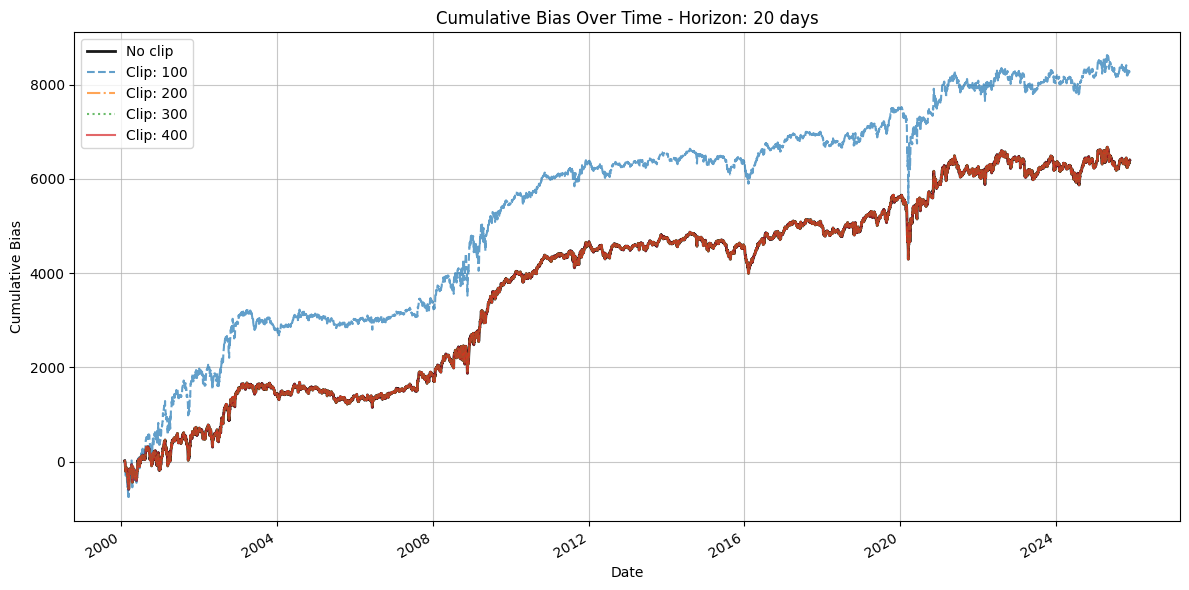

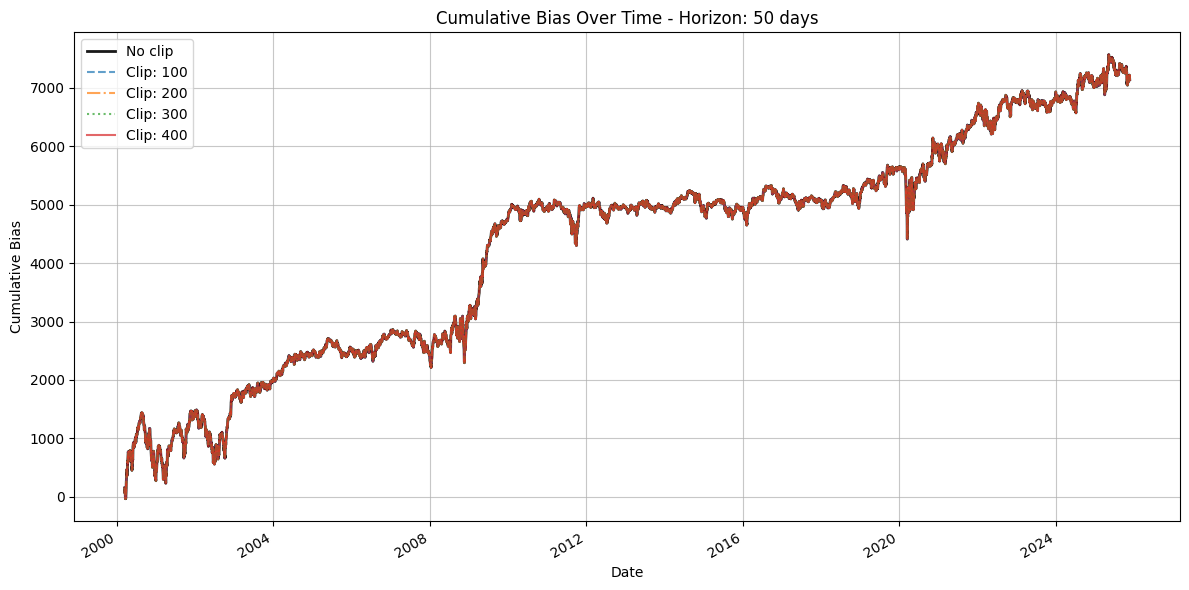

In [23]:
for h in [3, 5, 10, 20, 50]:
    plt.figure(figsize=(12, 6))
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(
        label=f'No clip', linewidth=2, linestyle='-', alpha=0.9, color='black'
    )
    for i, clip in enumerate([100, 200, 300, 400]):
        dict_results['avg_ret_hedged_clip'][(h, clip)][-1]['bias'].cumsum().plot(
            label=f'Clip: {clip}', linewidth=1.5, alpha=0.7, linestyle=['--', '-.', ':', '-'][i]
        )
    plt.legend()
    plt.title(f'Cumulative Bias Over Time - Horizon: {h} days')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Bias')
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [18]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,high_low_ret,high_low_ret_hedged,volume,share_volume,close_1d_ret_hedged_lag1,...,avg_ret_hedged_20d_clip300,avg_ret_hedged_20d_clip400,avg_ret_hedged_50d_clip100,avg_ret_hedged_50d_clip200,avg_ret_hedged_50d_clip300,avg_ret_hedged_50d_clip400,avg_ret_hedged_100d_clip100,avg_ret_hedged_100d_clip200,avg_ret_hedged_100d_clip300,avg_ret_hedged_100d_clip400
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,A,-794.643290,-403.651537,-241.422591,149.569162,617.596008,212.374028,4765083.0,0.001843,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.774906,-489.783152,-545.802166,-154.810413,891.704216,486.482235,512377600.0,0.198209,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.872162,101.119592,-127.855510,263.136244,291.991733,-113.230248,10734887.0,0.004153,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,54.791632,445.783386,109.292151,-295.929829,84600.0,0.000033,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.184197,-485.192443,-477.490397,-86.498643,935.074373,529.852392,7813200.0,0.003022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XEL,73.783110,-79.705079,68.763545,-34.043274,183.054148,55.603096,6340300.0,0.001986,-75.132233,...,9.590241,9.590241,17.523161,17.523161,17.523161,17.523161,11.411788,11.411788,11.411788,11.411788
2025-11-24,XOM,-95.259300,-248.747489,-105.503036,-208.309855,212.131705,84.680653,18034900.0,0.005650,-92.624573,...,25.712770,25.712770,9.760697,9.760697,9.760697,9.760697,1.228730,1.228730,1.228730,1.228730
2025-11-24,YUM,-124.976560,-278.464749,-133.471113,-236.277933,175.760582,48.309530,3656900.0,0.001146,151.773083,...,46.562699,46.562699,4.048306,4.048306,4.048306,4.048306,-3.524522,-3.524522,-3.524522,-3.524522


In [19]:
for h in [3, 5, 10, 20, 50]:
    df[f'open_close_ret_hedged_rolling_{h}'] = df.groupby('Ticker')['open_close_ret_hedged'].transform(lambda x: x.rolling(h).mean().shift())

In [ ]:
for h in tqdm([3, 5, 10, 20, 50]):
    dict_results[f'open_close_ret_hedged_rolling_{h}'] = single_feature_metrics(df, f'open_close_ret_hedged_rolling_{h}', 'close_1d_ret_hedged')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:17<00:00, 63.49s/it]


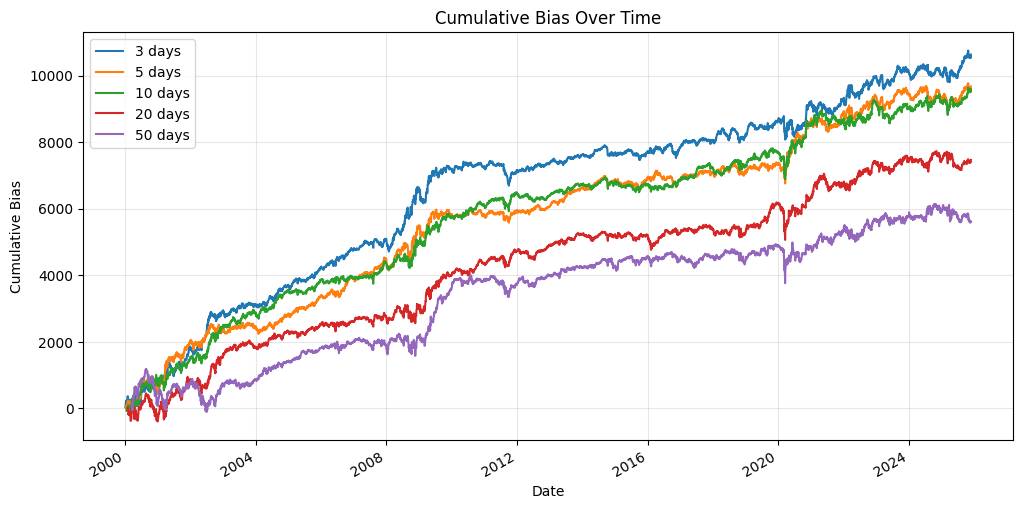

In [61]:
plt.figure(figsize=(12, 6))
for h in [3, 5, 10, 20, 50]:
    dict_results[f'open_close_ret_hedged_rolling_{h}'][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df[['open_close_ret_hedged_rolling_5', 'avg_ret_hedged_3d']].corr()

,open_close_ret_hedged_rolling_5,avg_ret_hedged_3d
open_close_ret_hedged_rolling_5,1.000000,0.616051
avg_ret_hedged_3d,0.616051,1.000000


In [ ]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

## Baseline models

### Random Strategy

In [38]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)


In [43]:
random_strat_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).mean())

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

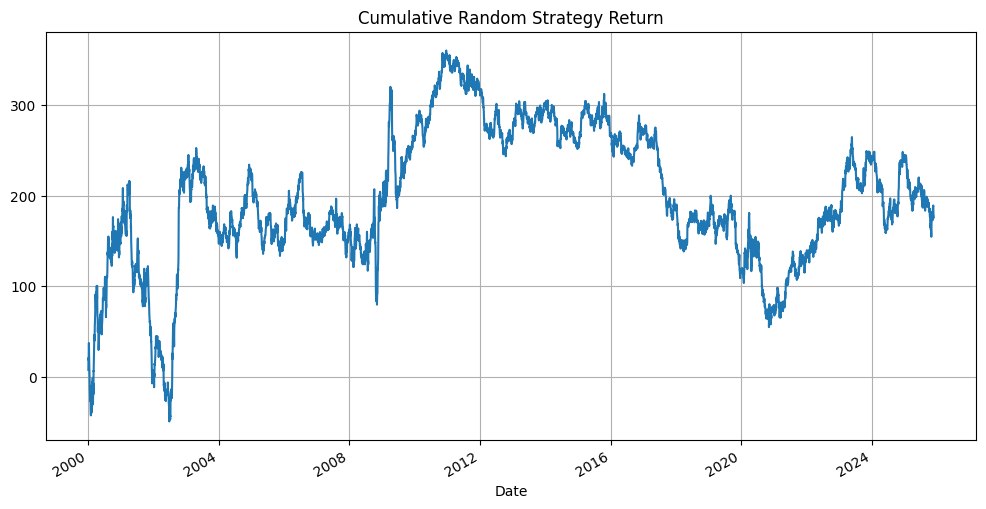

In [44]:
random_strat_returns.cumsum().plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

### Momentum Strategy

In [22]:
df['momentum_hedged_signal'] = df.groupby('Date')['close_1d_ret_hedged'].transform(
    lambda x: pd.cut(x.rank(method='first'), bins=10, labels=False, include_lowest=True)
).map(lambda x: 1 if x == 0 else (-1 if x == 9 else 0))

In [23]:
df['momentum_hedged_signal'] = df.groupby('Ticker')['momentum_hedged_signal'].shift()

In [24]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret'].transform(
    lambda x: pd.cut(x.rank(method='first'), bins=10, labels=False, include_lowest=True)
).map(lambda x: 1 if x == 0 else (-1 if x == 9 else 0))

In [25]:
df['momentum_signal'] = df.groupby('Ticker')['momentum_signal'].shift()

<Axes: title={'center': 'Cumulative Momentum Strategy Return'}, xlabel='Date'>

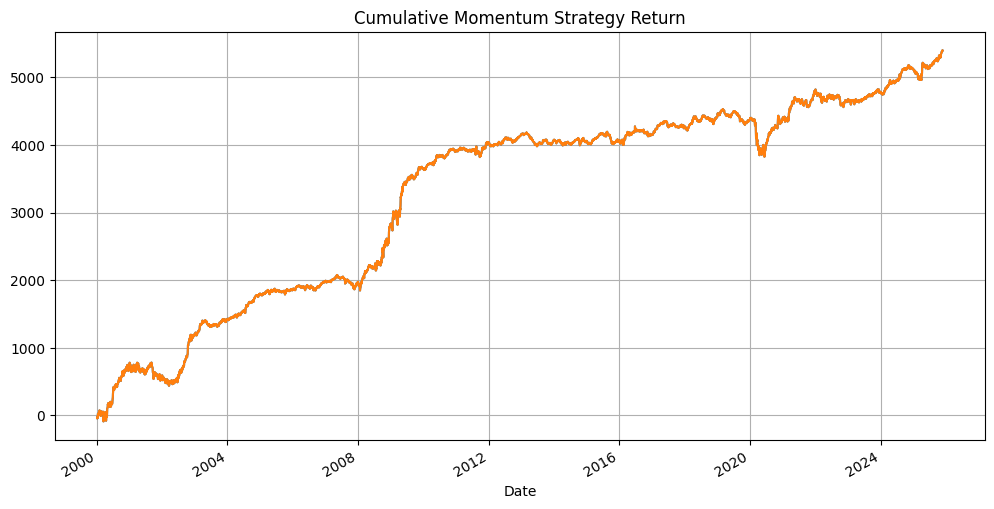

In [46]:
df.groupby('Date').apply(lambda x: (x['momentum_hedged_signal']*x['close_1d_ret']).mean()).cumsum().plot(figsize=(12,6), title='Cumulative Hedged Momentum Strategy Return', grid=True)
df.groupby('Date').apply(lambda x: (x['momentum_signal']*x['close_1d_ret']).mean()).cumsum().plot(figsize=(12,6), title='Cumulative Momentum Strategy Return', grid=True)

In [27]:
momentum_strat_returns = df.groupby('Date').apply(lambda x: (x['momentum_signal']*x['close_1d_ret']).mean())

In [28]:
momentum_strat_returns.mean()/momentum_strat_returns.std()*np.sqrt(252)

np.float64(0.9965486005776637)

### MACD Vol adjusted Strategy

In [ ]:
print('e')

In [ ]:
def compute_macd(df, price_col='return', fast=12, slow=26, signal=9):
    """
    Compute MACD indicator on a dataframe indexed by date with 'Ticker' and price columns.
    
    Parameters:
    - df: DataFrame with DatetimeIndex, columns 'Ticker' and price_col (e.g., 'return')
    - price_col: str, column name for price/return data (default: 'return')
    - fast, slow, signal: int, periods for EMAs (default: 12, 26, 9)
    
    Adds columns: 'MACD', 'MACD_signal', 'MACD_histogram'
    Handles multiple tickers via groupby.
    
    Assumes df is sorted by date.
    """
    def macd_group(series):
        exp_fast = series.ewm(span=fast, adjust=False).mean()
        exp_slow = series.ewm(span=slow, adjust=False).mean()
        macd_line = exp_fast - exp_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return pd.DataFrame({
            'MACD': macd_line,
            'MACD_signal': signal_line,
            'MACD_histogram': histogram
        }, index=series.index)
    
    # Group by Ticker and apply MACD calculation
    macd_df = df.groupby('Ticker')[price_col].apply(macd_group).droplevel(0)
    
    # Join back to original df
    df = df.join(macd_df)
    return df

In [47]:
df.head()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,high_low_ret,high_low_ret_hedged,volume,share_volume,close_1d_ret_hedged_lag1,...,avg_ret_hedged_100d_clip300,avg_ret_hedged_100d_clip400,open_close_ret_hedged_rolling_3,open_close_ret_hedged_rolling_5,open_close_ret_hedged_rolling_10,open_close_ret_hedged_rolling_20,open_close_ret_hedged_rolling_50,momentum_hedged_signal,momentum_signal,random_signal
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,A,-794.643290,-403.651537,-241.422591,149.569162,617.596008,212.374028,4765083.0,0.001843,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04,AAPL,-880.774906,-489.783152,-545.802166,-154.810413,891.704216,486.482235,512377600.0,0.198209,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04,ABT,-289.872162,101.119592,-127.855510,263.136244,291.991733,-113.230248,10734887.0,0.004153,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04,ACGL,-54.500128,336.491626,54.791632,445.783386,109.292151,-295.929829,84600.0,0.000033,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04,ADBE,-876.184197,-485.192443,-477.490397,-86.498643,935.074373,529.852392,7813200.0,0.003022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
df[df['Ticker']=='AAPL']['close_1d_ret'].ewm(span=12, adjust=False).mean()